In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


import torch
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

from sklearn import preprocessing
from skimage import data, color, img_as_float
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.kernel_approximation import RBFSampler

import os
import requests
import warnings

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print(torch.cuda.is_available())


True


In [2]:
def factorize(A, k, epsilon = 0.001,device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    A=A.to(device)
    
    #Randomly initialize W,H
    W = torch.randn(A.shape[0], A.shape[1], k, requires_grad=True, device=device)
    H = torch.randn(A.shape[0], k, A.shape[2], requires_grad=True, device=device)
    
    #optimizer
    optimizer=optim.Adam([W,H],lr=0.01)
    
    mask=~torch.isnan(A)
    
    epoch=0;
    while(True):
        epoch+=1
        # Compute the loss
        diff_mat=A-torch.matmul(W,H)
        diff_vect=diff_mat[mask]
        loss=torch.norm(diff_vect)
        
        # Zero the gradients
        optimizer.zero_grad()
        
                # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        if epoch>1:
            if(abs(prev_loss-loss)<epsilon):
                break
        prev_loss=loss
        
        if(epoch>10000):
            print("maximum epoch limit riched")
            break
    return W,H,loss

In [3]:
def plot_images(actual_image,masked_image,reconstructed_image):
    actual_image=actual_image.detach().cpu()
    masked_image=masked_image.detach().cpu()
    reconstructed_image=reconstructed_image.detach().cpu()
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(masked_image.permute(1, 2, 0) / 255)
    ax[0].set_title("masked image")
    ax[1].imshow(actual_image.permute(1, 2, 0) / 255)
    ax[1].set_title("Original image")
    ax[2].imshow(reconstructed_image.permute(1, 2, 0) / 255)
    ax[2].set_title("Reconstructed image")
    plt.show()
    return

In [4]:
import math
def compute_metrics(original, reconstructed, mask=None):
    # If mask provided, evaluate only masked pixels
    original = original.detach().cpu()/255
    reconstructed = reconstructed.detach().cpu()/255

    if mask is not None:
        diff = (reconstructed - original)[:,mask]
    else:
        diff = (reconstructed - original).view(-1)
        
    rmse = torch.sqrt(torch.mean(diff**2)).item()
    
    # PSNR
    mse = torch.mean(diff**2).item()
    if mse == 0:
        psnr = float('inf')
    else:
        psnr = 20 * math.log10(1.0 / math.sqrt(mse))  # assuming image in [0,1]
    
    return rmse, psnr

In [ ]:
import torch

def factorize_als(A, k, epsilon=0.001, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    """
    Alternating Least Squares version of your 3D factorization (C × H × W)
    A: input image tensor (with NaNs)
    k: latent dimension
    """
    A = A.to(device)
    mask = ~torch.isnan(A)

    # Randomly initialize W and H (same shape as your GD version)
    W = torch.randn(A.shape[0], A.shape[1], k, device=device)
    H = torch.randn(A.shape[0], k, A.shape[2], device=device)

    epoch = 0
    prev_loss = float('inf')

    while True:
        epoch += 1

        # ----- Update W for each channel -----
        for c in range(A.shape[0]):
            for i in range(A.shape[1]):
                cols = mask[c, i, :]        # valid pixels in this row
                if cols.sum() == 0:
                    continue
                X = H[c, :, cols].T          # shape: (#valid, k)
                y = A[c, i, cols].unsqueeze(1)  # (#valid, 1)
                sol = torch.linalg.lstsq(X, y).solution  # Solve X*w_i = y
                W[c, i, :] = sol[:, 0]

        # ----- Update H for each channel -----
        for c in range(A.shape[0]):
            for j in range(A.shape[2]):
                rows = mask[c, :, j]         # valid pixels in this column
                if rows.sum() == 0:
                    continue
                X = W[c, rows, :]            # shape: (#valid, k)
                y = A[c, rows, j].unsqueeze(1)
                sol = torch.linalg.lstsq(X, y).solution  # Solve X*h_j = y
                H[c, :, j] = sol[:, 0]

        # ----- Compute loss -----
        recon = torch.matmul(W, H)
        diff = (A - recon)[mask]
        loss = torch.norm(diff)

        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

        # ----- Check for convergence -----
        if abs(prev_loss - loss.item()) < epsilon:
            print("Converged")
            break

        prev_loss = loss.item()

        if epoch > 10000:
            print("Maximum epoch limit reached")
            break

    return W, H, loss


torch.Size([3, 1066, 1600])


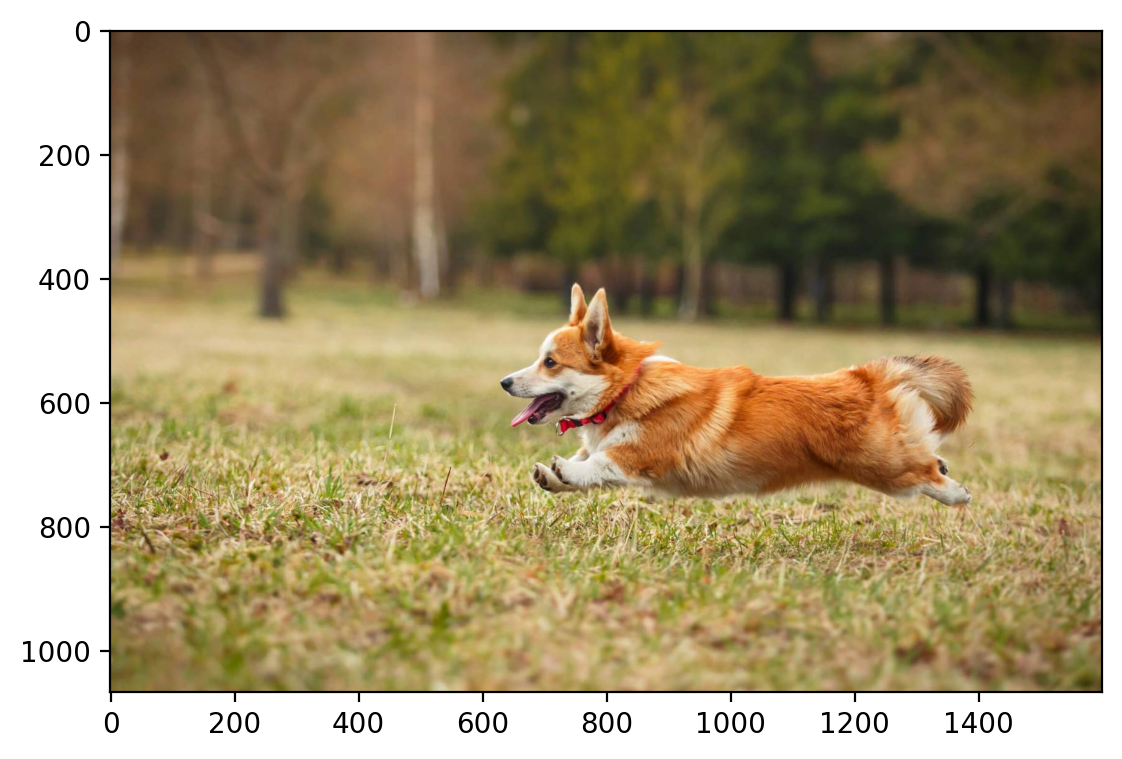

In [6]:
img=torchvision.io.read_image("dog (1).jpg").float()
img_colored=img/255
print(img_colored.shape)
plt.imshow(img_colored.permute(1,2,0))

torch.Size([3, 300, 300])


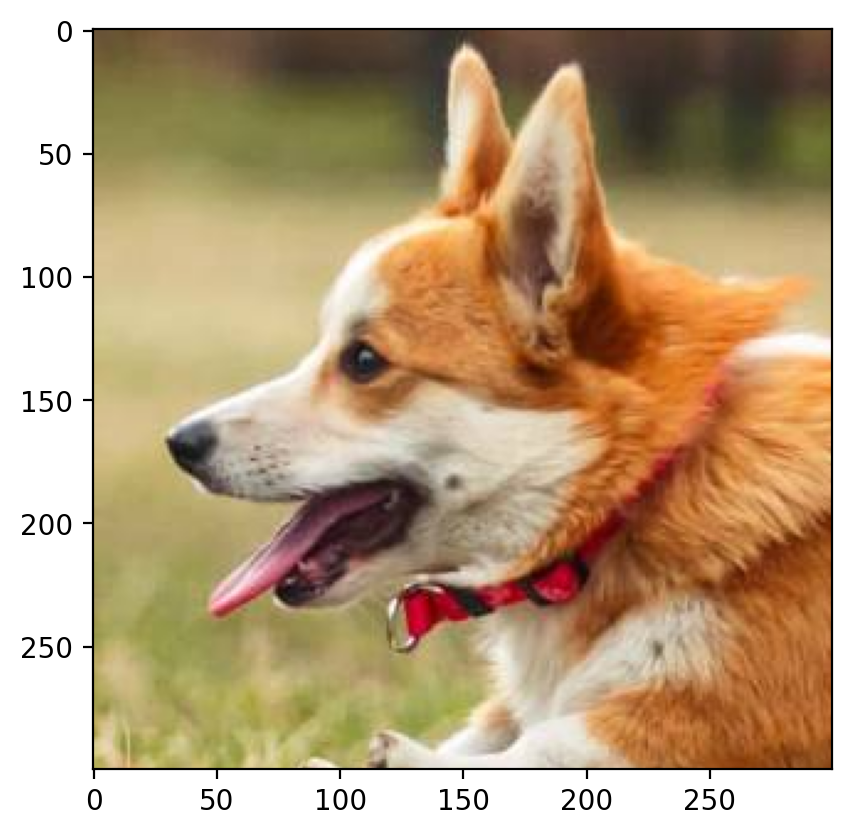

In [7]:
crop_img = torchvision.transforms.functional.crop(img, 400, 600, 300, 300)
print(crop_img.shape)
plt.imshow(crop_img.permute(1, 2, 0)/255)

1)

In [9]:
def mask_rect(img, top, left, height, width):
    img_copy = img.clone()
    mask = torch.zeros(img.shape[1:], dtype=torch.bool)
    mask[top:top+height, left:left+width] = True
    img_copy[:, mask] = float('nan')
    return img_copy, mask

masked_img_rect, mask_rect_block = mask_rect(crop_img, 75, 75, 30, 30)
print(masked_img_rect.shape,mask_rect_block.shape)
# Factorization
W, H, loss = factorize(masked_img_rect, 450)

# Plot
plot_images(crop_img,masked_img_rect,torch.matmul(W,H))
rmse,psnr=compute_metrics(crop_img,torch.matmul(W,H),mask_rect_block)
print(f'rmse:{rmse}',f'psnr:{psnr}')

w_ALS,H_ALS,loss_ALS=factorize_als(masked_img_rect,10)

torch.Size([3, 300, 300]) torch.Size([300, 300])


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.019252425..1.0204748].


torch.Size([3, 300, 300]) torch.Size([3, 300, 300])


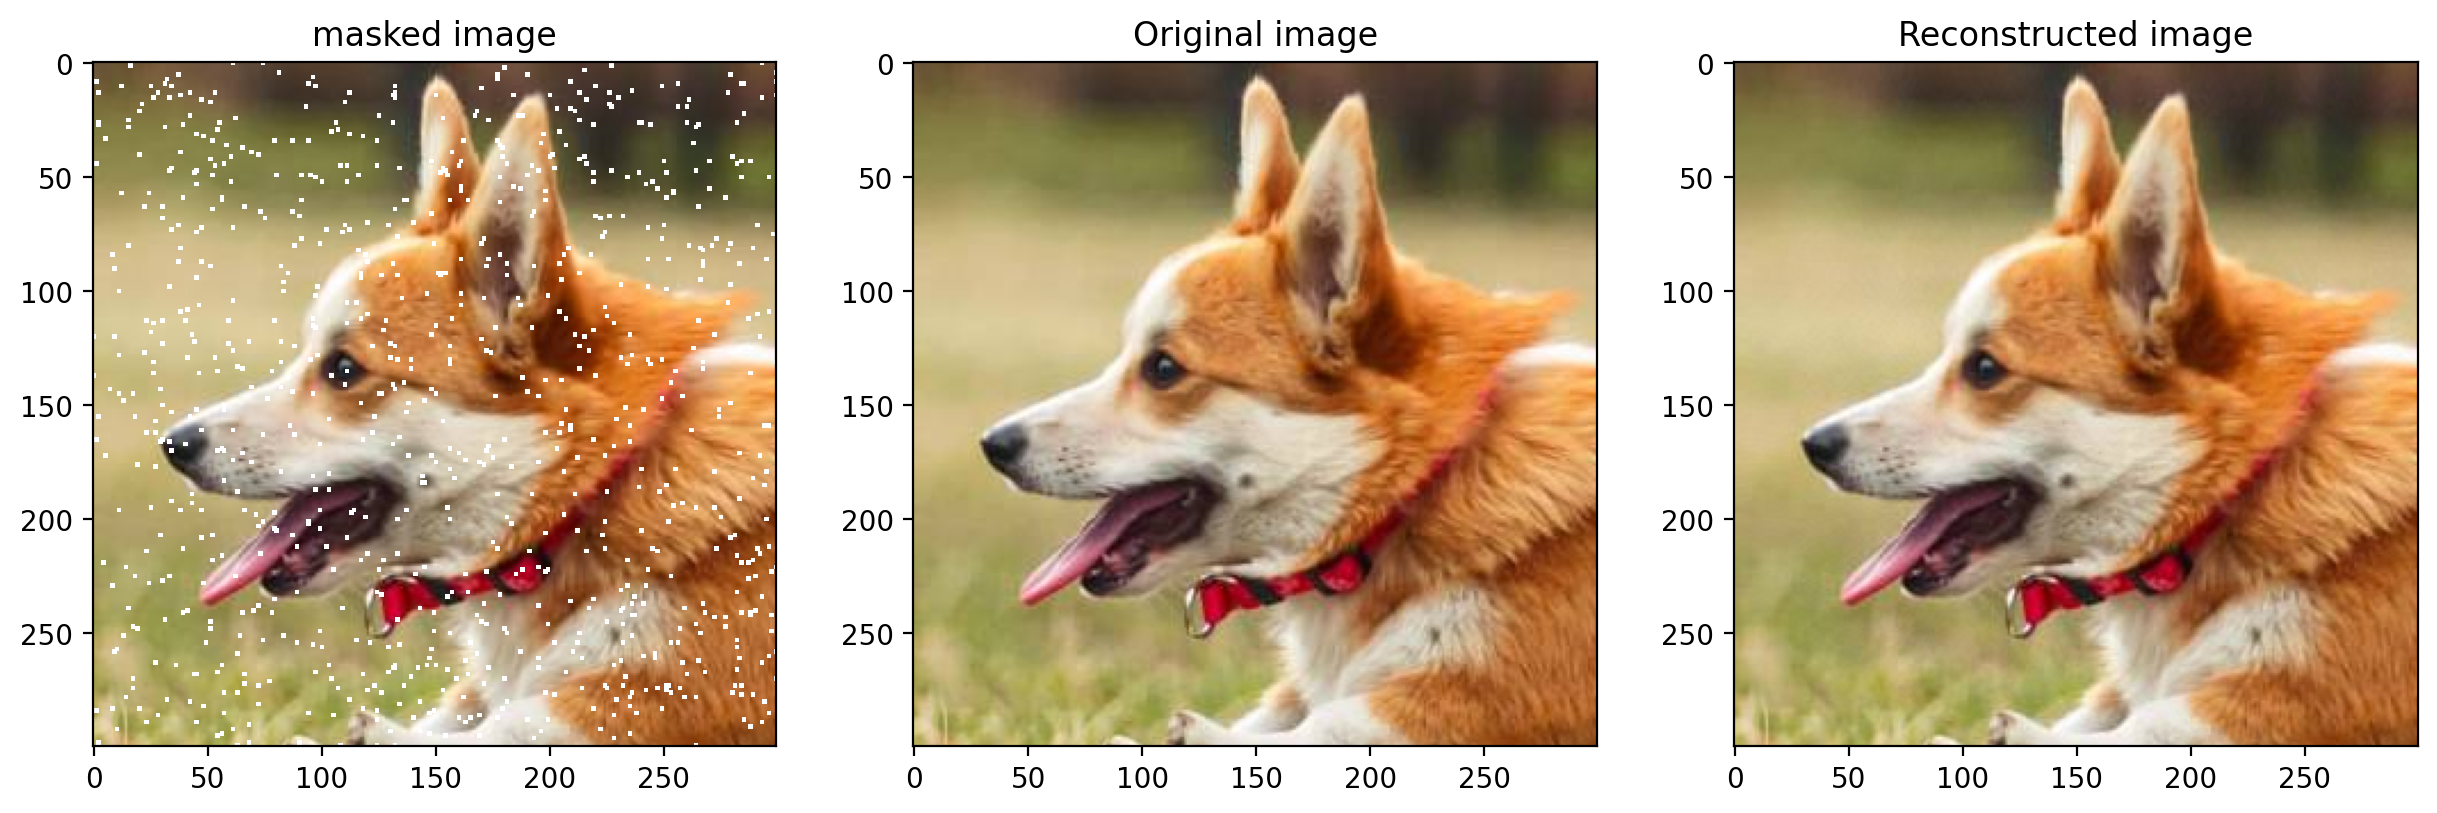

rmse:0.015158042311668396 psnr:36.38713749256478


In [10]:
# Mask the image with NaN values
def mask_random_pixels(img, num_pixels=900):
    img_copy = img.clone()                  
    h, w = img.shape[1], img.shape[2]      # Get height and width
    mask = torch.zeros(h*w, dtype=torch.bool)  # Initialize a flat boolean mask

    # Randomly select num_pixels positions
    indices = torch.randperm(h*w)[:num_pixels]
    mask[indices] = True

    mask = mask.view(h, w)                  # Reshape mask back to 2D (H x W)

    # 6. Apply NaN mask on all channels
    img_copy[:, mask] = float('nan')

    return img_copy, mask

masked_img_rand, mask_rand_block = mask_random_pixels(crop_img)

#Factorize

W, H, loss = factorize(masked_img_rand, 100)

print(torch.matmul(W, H).shape,masked_img_rand.shape)
plot_images(crop_img,masked_img_rand,torch.matmul(W,H))
rmse,psnr=compute_metrics(crop_img,torch.matmul(W,H),mask_rand_block)
print(f'rmse:{rmse}',f'psnr:{psnr}')

In [13]:
w_ALS,H_ALS,loss_ALS=factorize_als(masked_img_rand,50)

Epoch 1, Loss: 6524.0215
Epoch 2, Loss: 2330.7966
Epoch 3, Loss: 2139.7800
Epoch 4, Loss: 2096.8635
Epoch 5, Loss: 2081.8228
Epoch 6, Loss: 2075.0503
Epoch 7, Loss: 2071.4006
Epoch 8, Loss: 2069.1663
Epoch 9, Loss: 2067.6763
Epoch 10, Loss: 2066.6235
Epoch 11, Loss: 2065.8462
Epoch 12, Loss: 2065.2485
Epoch 13, Loss: 2064.7703
Epoch 14, Loss: 2064.3733
Epoch 15, Loss: 2064.0330
Epoch 16, Loss: 2063.7344
Epoch 17, Loss: 2063.4680
Epoch 18, Loss: 2063.2283
Epoch 19, Loss: 2063.0117
Epoch 20, Loss: 2062.8164
Epoch 21, Loss: 2062.6409
Epoch 22, Loss: 2062.4839
Epoch 23, Loss: 2062.3440
Epoch 24, Loss: 2062.2202
Epoch 25, Loss: 2062.1111
Epoch 26, Loss: 2062.0151
Epoch 27, Loss: 2061.9309
Epoch 28, Loss: 2061.8569
Epoch 29, Loss: 2061.7925
Epoch 30, Loss: 2061.7358
Epoch 31, Loss: 2061.6863
Epoch 32, Loss: 2061.6426
Epoch 33, Loss: 2061.6045
Epoch 34, Loss: 2061.5708
Epoch 35, Loss: 2061.5413
Epoch 36, Loss: 2061.5149
Epoch 37, Loss: 2061.4917
Epoch 38, Loss: 2061.4714
Epoch 39, Loss: 2061.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.117626496..1.0429678].


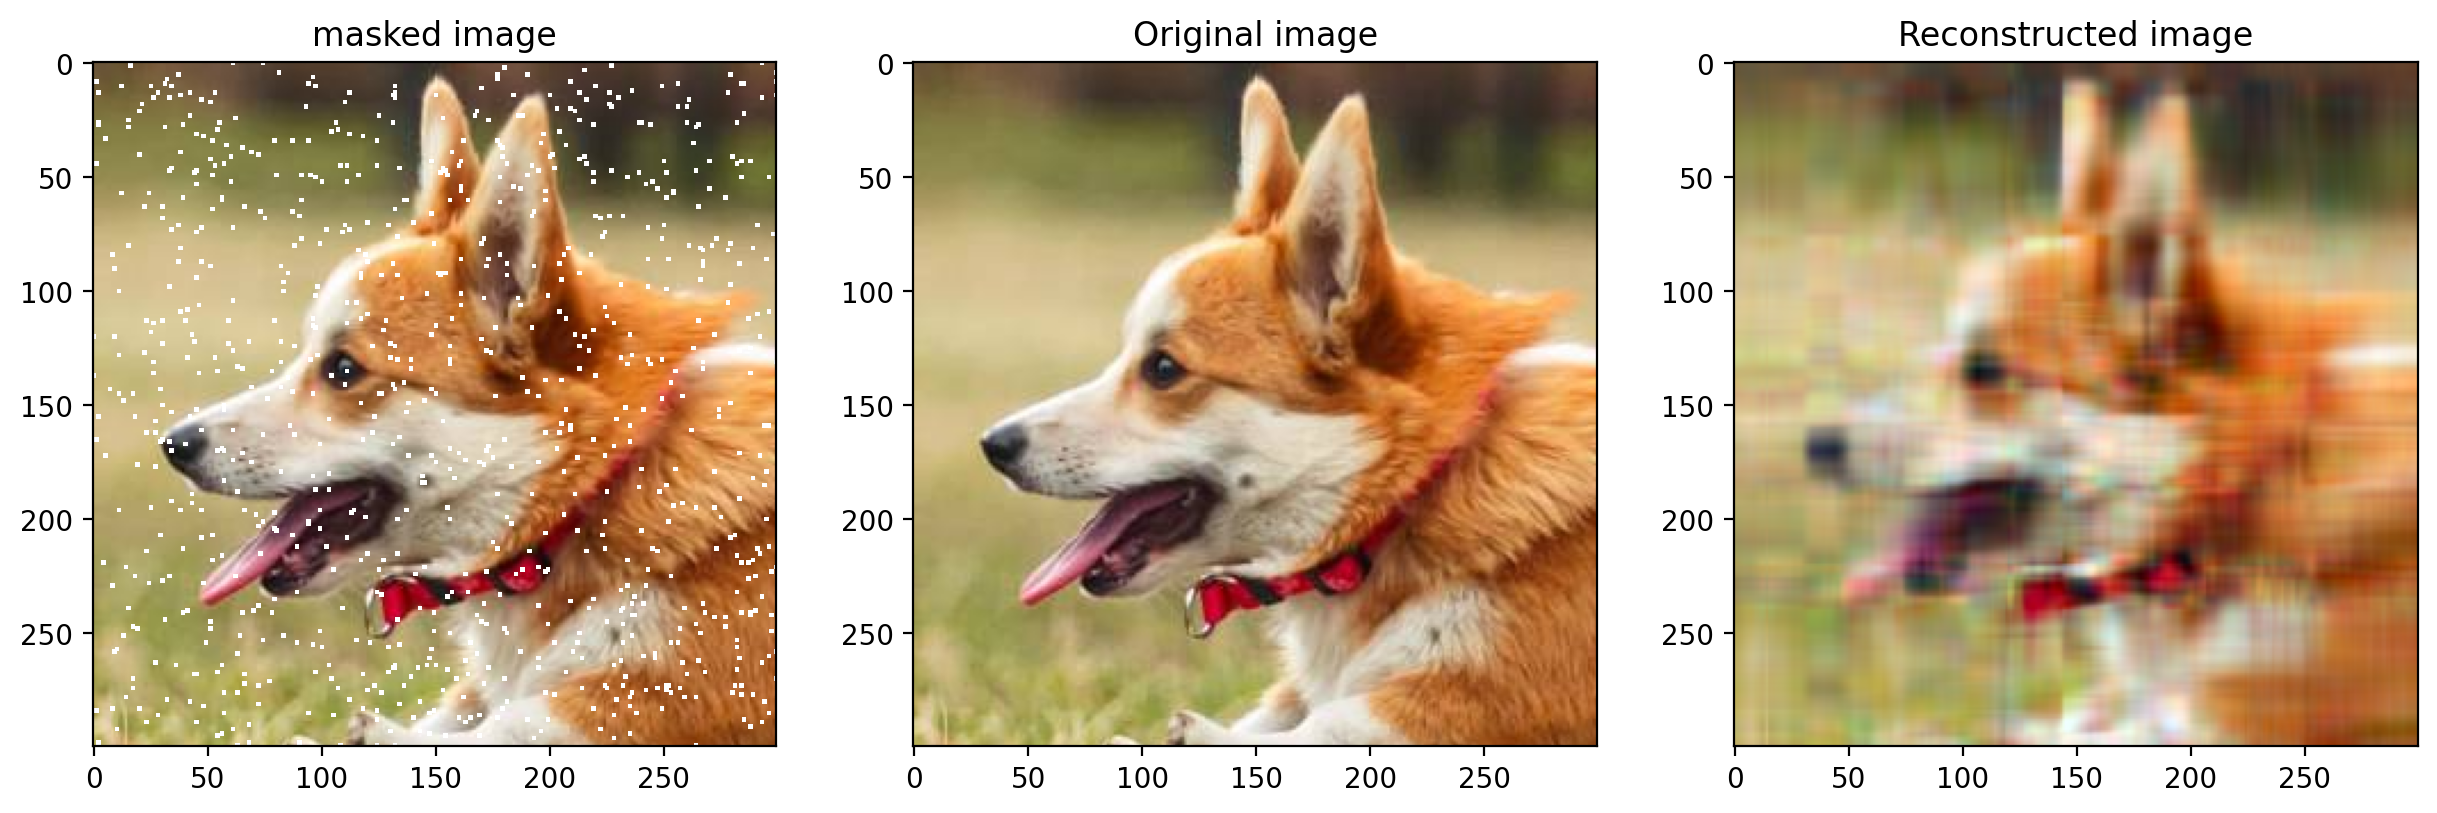

In [12]:
plot_images(crop_img,masked_img_rand,torch.matmul(w_ALS,H_ALS))

Task B